<a href="https://colab.research.google.com/github/gracecarrillo/Political-Data-Science/blob/master/Models_Definition_%26_Training_Sentiment_Analysis_Scotref2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scottish independence: Twitter data Sentiment Analysis




## 5. Supervised Machine Learning Models
  - Naive Bayes
  - Support Vector Machine

## 6. Deep Learning Model
  - LSTM Recurrent Neural Network

In [0]:
# Must be upgraded
!pip install tqdm==4.36.1 --upgrade

In [0]:
!pip install --upgrade gensim 

In [0]:
!pip install vaderSentiment

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# general
import os
import time
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
from collections import Counter

# tweets
import tweepy as tw
import re
from collections import Counter
from string import punctuation
from tweepy import OAuthHandler
import json

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 

# plots
from wordcloud import WordCloud
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Deep Learning
import torch
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Embedding, LSTM

# For geoplots
from IPython.display import IFrame
import folium
from folium import plugins
from folium.plugins import MarkerCluster, FastMarkerCluster, HeatMapWithTime
import networkx

# hide warnings
import warnings
warnings.filterwarnings("ignore")


# set plot preferences
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option("display.max_colwidth", 200) 

print('Libraries imported')
%matplotlib inline

## 5. Modeling 

We are now done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with the new feature sets.

We will use the following algorithms to build models:

- Naive Bayes Classifier
- Support Vector Machine


In [0]:
# Load back in
train_prep = pd.read_csv('/content/drive/My Drive/Twitter_Project/feat_eng_train_data.csv')

### 5.1 Preparing data for modeling

We'll first double check for missings, extract features from the train dataset and finally, split the data into train and test sets for modeling.

In [0]:
# Double hecking for missing values
train_prep.isnull().values.any()

False

In [0]:
train_prep.shape

(47824, 14)

In [0]:
train_prep.head(3)

,label,text,word count,tidy_tweet,tokens,neg_scores,neu_scores,pos_scores,compound_scores,NOUN,PRON,VERB,ADJ,ADV
0,4.0,is it LOVE or BREAD???,5.0,love bread,"['love', 'bread']",0.000,0.192,0.808,0.6369,1.0,0.0,0.0,0.0,0.0
1,0.0,now doing the weights again...urgh my poor laptop is burning up in this summer evening's heat,16.0,weight urgh poor laptop burn summer even heat,"['weights', 'urgh', 'poor', 'laptop', 'burning', 'summer', 'evening', 'heat']",0.307,0.693,0.000,-0.4767,1.0,0.0,0.0,1.0,1.0
2,4.0,just done my weekly weigh in. on target woohoo,9.0,done weekli weigh target woohoo,"['done', 'weekly', 'weigh', 'target', 'woohoo']",0.000,0.548,0.452,0.5106,1.0,0.0,1.0,1.0,0.0


In [0]:
# Extracting Features
features = ['tidy_tweet', 'neu_scores', 'neg_scores', 'compound_scores', 'pos_scores']
label = ['label']

# Saving features and label data in X and y for train-test split
X = train_prep[[col for col in train_prep.columns if col in features]]
y = train_prep[label]

X.shape, y.shape

((47824, 5), (47824, 1))

In [0]:
# splitting data into training and validation set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print("Shapes are {} and {}".format(X_train.shape, X_test.shape))

### 5.2 Baseline

We need a basis for comparison of results. When we start collecting results from our models, the baseline result will tell us if our models are adding value. 

For classification problems, the one rule is to predict the class value that is most common in the training dataset (Zero Rule Algorithm).

In [0]:
# Where 4 = positive and 0 = negative

pd.Series(y_train.values.ravel()).value_counts(normalize=True)
pd.Series(y_train.values.ravel()).value_counts(normalize=True)

0.0    0.504541
4.0    0.495459
dtype: float64

Our training dataset has 50.45% of instances of class `0.0` or negative and 49.54% of instances of class `4.0` or positive. Which means, it will predict *positive* and achieve a baseline accuracy of 50.45%

### 5.3 Supervised Machine Learning Models

For this classification project, we'll be using two algorightms: **Naive Bayes Classifier** and **Support Vector Machine Classifier**. They are arguably two of the most used techniques for any classification task.

For the source code of the helper functions and pipelines, check [this notebook](https://github.com/vtoliveira/advanced-data-science-capstone/blob/master/Model%20Definition%20and%20Training%20(Classical%20Algorithms)%20-%20Twitter%20US%20Airline%20Sentiment.ipynb).

In [0]:
# Helper functions

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [0]:
# Pipeline to convert tweets to a matrix of TF-IDF features.
tfidf = Pipeline([
                ('selector', TextSelector(key='tidy_tweet')),
                ('tfidf', TfidfVectorizer())
            ])

# Pipeline to convert tweets to a matrix of token counts
countvect = Pipeline([
                ('selector', TextSelector(key='tidy_tweet')),
                ('countvect', CountVectorizer())
            ])

In [0]:
# Applying tfidf anf countvec to features

neu_scores =  Pipeline([
                ('selector', NumberSelector(key='neu_scores')),
                ('minmax', MinMaxScaler())
            ])
neg_scores =  Pipeline([
                ('selector', NumberSelector(key='neg_scores')),
                ('minmax', MinMaxScaler())
            ])
pos_scores =  Pipeline([
                ('selector', NumberSelector(key='pos_scores')),
                ('minmax', MinMaxScaler())
            ])

compound_scores =  Pipeline([
                ('selector', NumberSelector(key='compound_scores')),
                ('minmax', MinMaxScaler())
            ])

In [0]:
# defining different sets of text processors
def features_union(textProcessor):
    return FeatureUnion([('text', textProcessor),
                      ('neu_scores', neu_scores),
                      ('neg_scores', neg_scores),
                      ('pos_scores', pos_scores),
                      ('compound_scores', compound_scores)])

In [0]:
# Normalise labels
le = LabelEncoder().fit(y_train.values.ravel())

y_train = le.transform(y_train.values.ravel())
y_test = le.transform(y_test.values.ravel())

X_train.shape, X_test.shape

((33476, 5), (14348, 5))

### 5.3.1 Naive Bayes Classifier  

In [0]:
# instantiate classifier
clf = MultinomialNB()

# combine features
features_count = features_union(countvect)

# define pipeline object 
nb_pipeline = Pipeline([('features', features_count),
                       ('nb', clf)])

# Fit classifier
nb_pipeline.fit(X_train, y_train)

# score
nb_pipeline.score(X_test, y_test)

0.7354335098968497

### 5.3.2 Support Vector Machine Classifier

In [0]:
# instantiate classifier
svm = LinearSVC()

#  combine features
features_tfidf = features_union(tfidf)

# define pipeline object
svm_pipeline = Pipeline([('features', features_tfidf),
                       ('svm', svm)])

# Fit classifier
svm_pipeline.fit(X_train, y_train)

# score
svm_pipeline.score(X_test, y_test)

0.7303456927794815

### 5.3.3 Cross-Validation

For each model, we will now do a k-fold cross-validation using Exhaustive Grid Search. Cross-validation using Scikit Learn's Grid Search.

In [0]:
# Naive Bayes Classifier

# combine features
features_tfidf = features_union(tfidf)

# instantiate pipeline object
nb_pipeline = Pipeline([('feats', features_tfidf),  ('clf', MultinomialNB())])

# parameter grid (3x3x2x2x3x3x2) combinations
parameters = {
    'feats__text__tfidf__max_df': (0.5, 0.75, 1.0),
    'feats__text__tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)), 
    'feats__text__tfidf__use_idf': (False, True),
    'feats__text__tfidf__binary':(False, True),
    'feats__text__tfidf__binary':('l1', 'l2', None),
    'clf__alpha': (1.0, 5.0, 10.0),
    'clf__fit_prior': (True, False),     
}

# instantiate GridSearchCV object with pipeline and parameters with 3-folds cross-validation
nb_grid = GridSearchCV(nb_pipeline, parameters, cv=3) # this takes a while :/

# start time 
nb_start = time.time()

# Fit 
nb_grid.fit(X_train, y_train)

# end time 
svm_end = time.time()
print(f"Time taken to run: {round((nb_end - nb_start)/60,1)} minutes")

# Check score
nb_grid.score(X_test, y_test)


0.7428909952606635

In [0]:
print('Best params: {}'.format(nb_grid.best_params_))
nb_cv_results = pd.DataFrame(nb_grid.cv_results_)
nb_cv_results.head(3)

Best params: {'clf__alpha': 1.0, 'clf__fit_prior': False, 'feats__text__tfidf__binary': 'l1', 'feats__text__tfidf__max_df': 0.5, 'feats__text__tfidf__ngram_range': (1, 2), 'feats__text__tfidf__use_idf': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_clf__fit_prior,param_feats__text__tfidf__binary,param_feats__text__tfidf__max_df,param_feats__text__tfidf__ngram_range,param_feats__text__tfidf__use_idf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.229720,0.006067,0.100113,0.001856,1,True,l1,0.5,"(1, 1)",False,"{'clf__alpha': 1.0, 'clf__fit_prior': True, 'feats__text__tfidf__binary': 'l1', 'feats__text__tfidf__max_df': 0.5, 'feats__text__tfidf__ngram_range': (1, 1), 'feats__text__tfidf__use_idf': False}",0.738059,0.740299,0.739918,0.739425,0.000979,19
1,0.224705,0.000837,0.102581,0.000896,1,True,l1,0.5,"(1, 1)",True,"{'clf__alpha': 1.0, 'clf__fit_prior': True, 'feats__text__tfidf__binary': 'l1', 'feats__text__tfidf__max_df': 0.5, 'feats__text__tfidf__ngram_range': (1, 1), 'feats__text__tfidf__use_idf': True}",0.730711,0.733847,0.731672,0.732077,0.001312,175
2,0.629810,0.016253,0.168072,0.002855,1,True,l1,0.5,"(1, 2)",False,"{'clf__alpha': 1.0, 'clf__fit_prior': True, 'feats__text__tfidf__binary': 'l1', 'feats__text__tfidf__max_df': 0.5, 'feats__text__tfidf__ngram_range': (1, 2), 'feats__text__tfidf__use_idf': False}",0.741016,0.745676,0.744130,0.743607,0.001938,10


In [0]:
# Support Vector Classifier

# combine features
features_count = features_union(tfidf)

# instantiate pipeline
svm_count_pipeline = Pipeline([('feats', features_count),  ('clf', LinearSVC())])

# parameter grid (3x3x2x3x7x2) combinations
parameters = {
    'feats__text__tfidf__max_df': (0.5, 0.75, 1.0),
    'feats__text__tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)), 
    'feats__text__tfidf__use_idf': (False, True),
    'clf__loss': ('hinge', 'squared_hinge'),
    'clf__C': (0.1, 0.5, 0.6, 1, 4, 5, 10, 100),
    'clf__class_weight': (None, 'balanced')                                    
}

# instantiate GridSearchCV object with pipeline and parameters with 3-folds cross-validation
svm_grid = GridSearchCV(svm_count_pipeline, parameters, cv=3)

# start time 
svm_start = time.time()

# fit
svm_grid.fit(X_train, y_train)

# end time 
svm_end = time.time()
print(f"Time taken to run: {round((svm_end - svm_start)/60,1)} minutes")

# score
svm_grid.score(X_test, y_test)

Time taken to run: 43.0 minutes


In [0]:
# score
svm_grid.score(X_test, y_test)


0.7513242263730137

In [0]:
print('Best params: {}'.format(svm_grid.best_params_))
svm_cv_results = pd.DataFrame(svm_grid.cv_results_)
svm_cv_results.head(3)

Best params: {'clf__C': 0.6, 'clf__class_weight': 'balanced', 'clf__loss': 'hinge', 'feats__text__tfidf__max_df': 0.5, 'feats__text__tfidf__ngram_range': (1, 2), 'feats__text__tfidf__use_idf': True}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__class_weight,param_clf__loss,param_feats__text__tfidf__max_df,param_feats__text__tfidf__ngram_range,param_feats__text__tfidf__use_idf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.302991,0.041557,0.105896,0.001908,0.1,None,hinge,0.5,"(1, 1)",False,"{'clf__C': 0.1, 'clf__class_weight': None, 'clf__loss': 'hinge', 'feats__text__tfidf__max_df': 0.5, 'feats__text__tfidf__ngram_range': (1, 1), 'feats__text__tfidf__use_idf': False}",0.723990,0.723990,0.723875,0.723951,0.000054,217
1,0.254545,0.005855,0.103313,0.000916,0.1,None,hinge,0.5,"(1, 1)",True,"{'clf__C': 0.1, 'clf__class_weight': None, 'clf__loss': 'hinge', 'feats__text__tfidf__max_df': 0.5, 'feats__text__tfidf__ngram_range': (1, 1), 'feats__text__tfidf__use_idf': True}",0.721928,0.722377,0.723875,0.722727,0.000832,238
2,0.669138,0.019907,0.183208,0.008977,0.1,None,hinge,0.5,"(1, 2)",False,"{'clf__C': 0.1, 'clf__class_weight': None, 'clf__loss': 'hinge', 'feats__text__tfidf__max_df': 0.5, 'feats__text__tfidf__ngram_range': (1, 2), 'feats__text__tfidf__use_idf': False}",0.720943,0.719957,0.722800,0.721233,0.001179,250


We passed the combined parameters to the GridsearchCV object for each classifier and 10 folds for the cross validation which means that for every parameter combination, the grid ran 10 different iterations with a different test set every time.

After trying out the different model parameter combinations, the GridsearchCV returns the best performing model per classifier.

We save the models below to the working directory for evaluation. This is also good for when we just want to retrieve the trained model in the future without retraining it and use it for classification of new text.
 
Also a necessary step if we plan to deploy the model.

In [0]:
# save best model per each classifier
joblib.dump(nb_grid, "/content/drive/My Drive/Twitter_Project/twitter_sentiment_naivebayes.pkl")
print('Naive Bayes Classifier saved')
joblib.dump(svm_grid, "/content/drive/My Drive/Twitter_Project/twitter_sentiment_svm.pkl")
print('SVM Classifier saved')

Naive Bayes Classifier saved
SVM Classifier saved


In [0]:
# Get and save predictions from best models above

# Naive Bayes
y_preds_nb = nb_grid.predict(X_test)
# Save predictions for evaluation as numpy arrays
np.save('/content/drive/My Drive/Twitter_Project/y_predsNB.npy', y_preds_nb)

# Support Vector Machine
y_preds_svm = svm_grid.predict(X_test)
# Save predictions for evaluation as numpy arrays
np.save('/content/drive/My Drive/Twitter_Project/y_predsSVM.npy', y_preds_svm)

In [0]:
# Save test data for evaluation in the next notebook
np.save('/content/drive/My Drive/Twitter_Project/y_test.npy', y_test)

## 6. Deep Learning Modeling

**Long Short-Term Memory (LSTMN) Recurrent Neural Network**

We will now implement a Recurrent Neural Network (RNN). Again, our goal is to identify whether a tweet is negative or positive.

The network arquitecture is as follows:

  - First, we'll pass in words to an embedding layer, our first hidden layer. We need an embedding layer because we have tens of thousands of words, so we'll need a more efficient representation for our input data than one-hot encoded vectors.
  
  - After input words are passed to an embedding layer, the new embeddings will be passed to LSTM cells, our second hidden layer. The LSTM cells will add recurrent connections to the network and give us the ability to include information about the sequence of words in tweets.

  - Finally, the LSTM outputs will go to a softmax output layer. We're using a softmax activation function and not sigmoid because we are using one hot encoding. The basic difference between Sigmoid and Softmax is that while both give output in [0,1] range, softmax ensures that the sum of outputs along channels (as per specified dimension) is 1 i.e., they are probabilities. Sigmoid just makes output between 0 to 1. Hence, if you are using a one hot encoding scheme where one channel has probabilities of one class and other channel has probabilities of another then you must use a Softmax activation.

Since we are using embeddings, we will have to encode the tweet's words to integers. For this purpose, we will convert the tweets into sequences of integers using `Tokenizer` from Keras. Then, the encoded tweets can be passed into the network.

### 6.1 Encoding the words

In [0]:
%tensorflow_version 1.x

# Parameter indicating the number of words
nb_words = 10000  

## create the tokenizer (tweets have been preprocessed so no need for filters)
tk = Tokenizer(num_words=nb_words)

# fit the tokenizer on tweets
tk.fit_on_texts(train_prep.tidy_tweet)

# integer encode tweets
tweets_seq = tk.texts_to_sequences(train_prep.tidy_tweet)


Let's print out the number of unique words in the vocabulary and the contents of the first, tokenized tweet.

In [0]:
# stats about vocabulary
print('Unique words: ', len((tweets_seq)))
print()

# print first encoded tweet
print('Encoded tweet: \n', tweets_seq[:1])

Unique words:  47824

Encoded tweet: 
 [[6, 1502]]


### 6.2 Equal lenght of sequences

Each batch needs to provide sequences of equal length. We achieve this with the `pad_sequences method`. By specifying a maximum length, the sequences are padded with zeros or truncated.

In [0]:
train_prep['word count'].describe()

count    47824.000000
mean        13.599427
std          6.845686
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max         39.000000
Name: word count, dtype: float64

In [0]:
# Maximum length since maximum tweet word count is 39.
max_len = 39

# Convert sequences into 2-D Numpy arrays
features = pad_sequences(tweets_seq, maxlen=max_len)

In [0]:
# test statements 
assert len(features)==len(tweets_seq), "The features should have as many rows as tweets."
assert len(features[0])==max_len, "Each feature row should contain the mex length of values."

# print first 10 values of the first 30 batches 
print(features[:10,:10])

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


### 6.4 Split into Training, Validation, and Testing sets

With the tweets ready, we now split the data for training and validation. 


In [0]:
# to hot-encode
train_prep["label"] = train_prep["label"].astype("category")
train_prep.label.describe()

count     47824.0
unique        2.0
top           0.0
freq      24203.0
Name: label, dtype: float64

In [0]:
## split data into training and test data (features and labels, x and y)
# data needs to be as array
labels = pd.get_dummies(train_prep['label']).values
#labels = np.asarray(train_prep.label.values)

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42)

## print out the shapes of the resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set X: \t\t{}".format(X_train.shape),
      "\nTrain set Y: \t\t{}".format(Y_train.shape),
      "\nTest set X: \t\t{}".format(X_test.shape),
      "\nTest set Y: \t\t{}".format(Y_test.shape))

			Feature Shapes:
Train set X: 		(38259, 39) 
Train set Y: 		(38259, 2) 
Test set X: 		(9565, 39) 
Test set Y: 		(9565, 2)


### 6.5. LSTM Network with Keras

 In Keras we can simply stack multiple layers on top of each other. For this we need to initialise the model as `Sequential()`.


In [0]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [0]:
#--- Parameters----#

# encodes input sequence dense vectors 
embed_dim = 128

# transforms the vector sequence into a single vector
lstm_out = 200

# batch size of 32 is a good starting point
batch_size = 32

# epochs
nb_epoch = 10

#------# Build the LSTM model #-----------------#

print('Building model...') 

# Initialising the RNN
model = Sequential()

#adding an input layer and the first hidden layer
model.add(Embedding(2500, embed_dim, 
                    input_length = features.shape[1], 
                    dropout = 0.2)) 
# Adding the second hidden layer
model.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
# Adding the output layer
model.add(Dense(2, activation='softmax'))

# Compile model
model.compile( optimizer='adam', # optimazer
              loss = 'categorical_crossentropy', # loss function
              metrics = ['accuracy']) # list of metrics

model.name = 'LSTM model'
print(model.summary())

Building model...
Model: "LSTM model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 39, 128)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 583,602
Trainable params: 583,602
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# Fit the model
history = model.fit(X_train, Y_train, 
                    validation_split=0.33, 
                    batch_size = batch_size, 
                    nb_epoch = nb_epoch, verbose = True)

Train on 25633 samples, validate on 12626 samples
Epoch 1/10
25633/25633 [==============================] - 66s 3ms/step - loss: 0.5608 - acc: 0.7091 - val_loss: 0.5233 - val_acc: 0.7428
Epoch 2/10
25633/25633 [==============================] - 65s 3ms/step - loss: 0.4935 - acc: 0.7623 - val_loss: 0.5232 - val_acc: 0.7405
Epoch 3/10
25633/25633 [==============================] - 65s 3ms/step - loss: 0.4632 - acc: 0.7777 - val_loss: 0.5343 - val_acc: 0.7378
Epoch 4/10
25633/25633 [==============================] - 66s 3ms/step - loss: 0.4325 - acc: 0.7952 - val_loss: 0.5585 - val_acc: 0.7319
Epoch 5/10
25633/25633 [==============================] - 66s 3ms/step - loss: 0.4030 - acc: 0.8100 - val_loss: 0.5701 - val_acc: 0.7298
Epoch 6/10
25633/25633 [==============================] - 66s 3ms/step - loss: 0.3690 - acc: 0.8264 - val_loss: 0.6362 - val_acc: 0.7175
Epoch 7/10
25633/25633 [==============================] - 66s 3ms/step - loss: 0.3393 - acc: 0.8414 - val_loss: 0.6652 - val_acc

We ran the model for a 10 epochs. We can observe that the loss for the validation data beings to increase after the epoch 1, which suggest overfitting. Let's double check that with the help of the helper functions `eval_metric` and `optimal_epoch`. We'll then try to address the issue by tweeking our model and then test if there's any improvement. For the original source code of the helper functions, check [this very complete notebook.](https://github.com/bertcarremans/TwitterUSAirlineSentiment/blob/master/source/Handling%20overfitting%20in%20deep%20learning%20models.ipynb)

In [0]:
# Helper functions

def eval_metric(model, history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, nb_epoch + 1)

    plt.plot(e, metric, 'ro', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'r', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()


def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=nb_epoch
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results

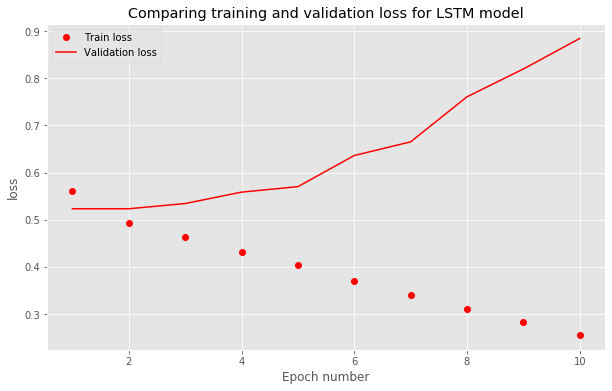

In [0]:
eval_metric(model, history, 'loss')


In [0]:
optimal_epoch(history)

Minimum validation loss reached in epoch 2


2

Two things we observe from the graphs are:

  - The training loss keeps decreasing after every epoch. Our model is learning to recognise the specific patterns in the training set.

  - The validation loss keeps increasing after every epoch. Our model is not generalising well enough on the validation set.

The training loss continues to go down and almost reaches zero at epoch 10. This is normal as the model is trained to fit the train data as good as possible.

So, we are **overtraining**. 

We can try to do something about the overfitting. We are already using a drop out layer, which randomly removes certain features by setting them to zero. 


We can apply regularisation, which comes down to adding a cost to the loss function for large weights.

There are L1 and L2 regularisation:

  - L1 regularisation will add a cost with regards to the absolute value of the parameters. It will result in some of the weights to be equal to zero.

  - L2 regularszation will add a cost with regards to the squared value of the parameters. This results in smaller weights.

Let's try with **L2 regularisation.**

In [0]:
# Applying regularisation

print('Building model...') 

reg_model = Sequential()
reg_model.add(Embedding(2500, embed_dim, input_length = features.shape[1], dropout = 0.2))
reg_model.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
reg_model.add(Dense(2, kernel_regularizer=regularizers.l2(0.001), activation='softmax'))

# Compile model
reg_model.compile( optimizer='adam', # optimazer
              loss = 'categorical_crossentropy', # loss function
              metrics = ['accuracy']) # list of metrics

reg_model.name = 'LSTM with Regularisation model'
print(reg_model.summary())

Building model...
Model: "LSTM with Regularisation model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 39, 128)           320000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 583,602
Trainable params: 583,602
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# Fit the model
reg_history = reg_model.fit(X_train, Y_train, 
                    validation_split=0.33, 
                    batch_size = batch_size, 
                    nb_epoch = nb_epoch, verbose = True)

Train on 25633 samples, validate on 12626 samples
Epoch 1/10
25633/25633 [==============================] - 68s 3ms/step - loss: 0.5628 - acc: 0.7056 - val_loss: 0.5214 - val_acc: 0.7429
Epoch 2/10
25633/25633 [==============================] - 67s 3ms/step - loss: 0.4964 - acc: 0.7609 - val_loss: 0.5227 - val_acc: 0.7418
Epoch 3/10
25633/25633 [==============================] - 67s 3ms/step - loss: 0.4667 - acc: 0.7780 - val_loss: 0.5255 - val_acc: 0.7362
Epoch 4/10
25633/25633 [==============================] - 68s 3ms/step - loss: 0.4359 - acc: 0.7949 - val_loss: 0.5564 - val_acc: 0.7328
Epoch 5/10
25633/25633 [==============================] - 68s 3ms/step - loss: 0.4045 - acc: 0.8102 - val_loss: 0.5889 - val_acc: 0.7297
Epoch 6/10
25633/25633 [==============================] - 67s 3ms/step - loss: 0.3743 - acc: 0.8268 - val_loss: 0.6047 - val_acc: 0.7226
Epoch 7/10
25633/25633 [==============================] - 67s 3ms/step - loss: 0.3445 - acc: 0.8410 - val_loss: 0.6713 - val_acc

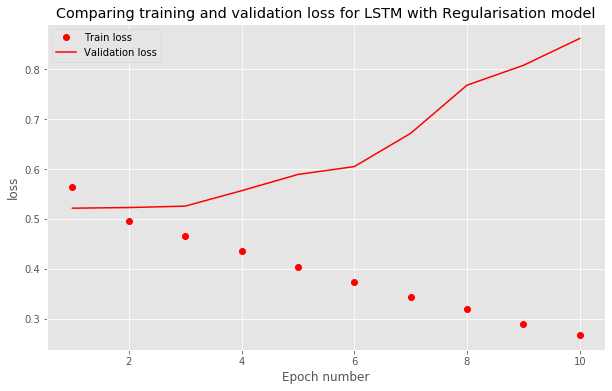

In [0]:
eval_metric(reg_model, reg_history, 'loss')

In [0]:
optimal_epoch(reg_history)

Minimum validation loss reached in epoch 1


1



We can see that it starts overfitting in the second epoch as the first model. Also, the validation loss increases slower afterwards.

At first sight the reduced model seems to be the best model for generalisation. But let's check that on the test set using the `test_model` helper function. 

In [0]:
# Optimal epochs
base_min = 1 # first model
reg_min = 2 # model with regularisation

# Training on the full train data and evaluation on test data on first model
base_results = test_model(model, X_train, Y_train, X_test, Y_test, base_min)

9565/9565 [==============================] - 10s 1ms/step

Test accuracy: 74.81%


In [0]:
# Training on second model with regularisation and evaluation on data on second model
reg_results = test_model(reg_model, X_train, Y_train, X_test, Y_test, reg_min)

9565/9565 [==============================] - 10s 1ms/step

Test accuracy: 74.47%


As shown above, applying regularisation helped with the overfitting but it didn't do much to the model's accuracy on the test data. We'll do a more comprehensive evaluation and compare both versions of the LSTM model with the machine learning models we trained previously, the Naive Bayes Classifier and Support Vector Machine Classifier. 

Let's save our models and predictions:

In [0]:
# save first model and architecture
model.save('/content/drive/My Drive/Twitter_Project/LSTM_model.h5')
print('Saved LSTM model to drive')

# save second model and architecture
reg_model.save('/content/drive/My Drive/Twitter_Project/LSTM_regmodel.h5')
print('Saved LSTM model to drive')

Saved LSTM model to drive
Saved LSTM model to drive


In [0]:
# saving predictions
X_train, X_test, Y_train, Y_test

#-- LSTM model ----#
y_preds_LSTM = model.predict(X_test)

# Save predictions for evaluation as numpy arrays
np.save('/content/drive/My Drive/Twitter_Project/y_predsLSTM.npy', y_preds_LSTM)
print('LSTM model predictions saved to drive')

#-- LSTM with regularisation model ----#
y_preds_LSTMreg = reg_model.predict(X_test)

# Save predictions for evaluation as numpy arrays
np.save('/content/drive/My Drive/Twitter_Project/y_predsLSTMreg.npy', y_preds_LSTMreg)
print('LSTM reg model predictions saved to drive')

# Save test data
np.save('/content/drive/My Drive/Twitter_Project/y_testLSTM.npy', Y_test)

LSTM model predictions saved to drive
LSTM reg model predictions saved to drive


In [0]:
# Save test data
np.save('/content/drive/My Drive/Twitter_Project/y_testLSTM.npy', Y_test)
print('Test data saved')

Test data saved
